In [1]:
import numpy as np
import scipy as sp
import scipy.linalg

from qiskit import  BasicAer, Aer, execute, assemble, QuantumCircuit
from qiskit.quantum_info.operators import Operator
backend = Aer.get_backend("qasm_simulator")

from qiskit.visualization import plot_histogram

from utils_decompose import global_phase_gate
from utils_block_encode import is_unitary
from utils import matrix_distance, universal_be

In [2]:
def phase_rotate(circuit, n):  
    if n == 0: return circuit    
    n = n-1
    circuit.h(n)    
    for qubit in range(n): circuit.cp(np.pi/2**(n-qubit), qubit, n)     
    phase_rotate(circuit, n)

def swap_registers(circuit, n):    
    for qubit in range(n//2): circuit.swap(qubit, n-qubit-1)
        
def qft(circuit, n, where):
    qc = QuantumCircuit(n)
    phase_rotate(qc,n)
    swap_registers(qc,n)
    qft = qc.to_gate()
    qft.name = " QFT "
    circuit.append(qft, range(where,n+where))

def qft_dagger(circuit, n, where):
    qc = QuantumCircuit(n)
    phase_rotate(qc,n)
    swap_registers(qc,n)
    
    qc_dagger = qc.inverse()
    qft_dagger = qc_dagger.to_gate()
    qft_dagger.name = " QFT$^\dagger$ "
    circuit.append(qft_dagger, range(where,n+where))

### Ex 1

$A = \begin{bmatrix}1 & -\frac{1}{3} \\-\frac{1}{3} & 1\end{bmatrix}$, $b = \begin{bmatrix}1\\0\end{bmatrix}\longrightarrow  x = \begin{bmatrix}1.125\\0.375\end{bmatrix}$

In [3]:
M = np.array([[1, -1/3], [-1/3, 1]])
b = np.array([1, 0])

classic_solution = np.linalg.solve(M,b)
norm = np.linalg.norm(classic_solution)
eigenvals,eigenvecs=np.linalg.eig(M)
print("Eigenvalues:",eigenvals)
print("Eigenvectors:\n",eigenvecs)
print("Euclidean norm:",norm)

Eigenvalues: [1.33333333 0.66666667]
Eigenvectors:
 [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
Euclidean norm: 1.1858541225631423


HHL

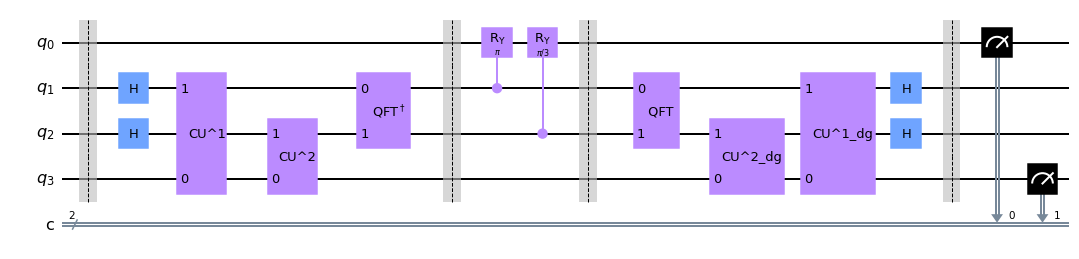

In [4]:
t = (3/4)*np.pi

def CU(A,num):
    qc = QuantumCircuit(2)
    U_A, C_U = np.eye(2, dtype='complex'), np.eye(4, dtype='complex')
    for i in range(num): U_A = U_A.dot(sp.linalg.expm(1j*A*t))
    C_U[2:4,2:4] = U_A 

    qc.unitary(Operator(C_U), range(2))
    CU_gate = qc.to_gate()
    CU_gate.name = "CU^{}".format(num)
    return CU_gate

qc = QuantumCircuit(4,2)
# qc.x(3)

qc.barrier()

qc.h([1,2])
qc.append(CU(M,1),[3,1])
qc.append(CU(M,2),[3,2])


qft_dagger(qc,2,1)
qc.barrier()

qc.cry(2*np.arcsin(1/1),1,0)
qc.cry(2*np.arcsin(1/2),2,0)
qc.barrier()

qft(qc,2,1)
qc.append(CU(M,2).inverse(),[3,2])
qc.append(CU(M,1).inverse(),[3,1])
qc.h([1,2])

qc.save_statevector()
qc.measure([0,3],[0,1])
qc.draw(output="mpl",fold=-1)

solution: [1.125 0.375]


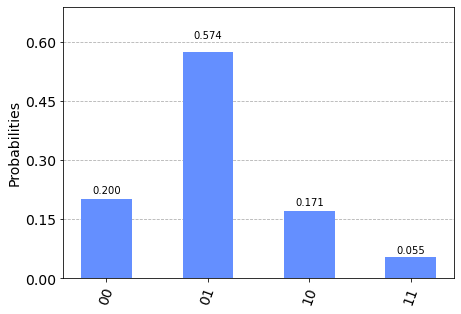

In [5]:
result = execute(qc, backend=backend, shots=1024, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[1], sv[9]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())

Block Encoding

In [6]:
M_inv = np.linalg.inv(M)
R = np.linalg.norm(M_inv)

if R > 1: 
    print("Inverse matrix:\n",np.round(M_inv,3))
    print("-> divisor:",R)
    M_inv = M_inv/R

print("Inverse matrix with norm < 1:\n",np.round(M_inv,3))

Inverse matrix:
 [[1.125 0.375]
 [0.375 1.125]]
-> divisor: 1.6770509831248424
Inverse matrix with norm < 1:
 [[0.671 0.224]
 [0.224 0.671]]


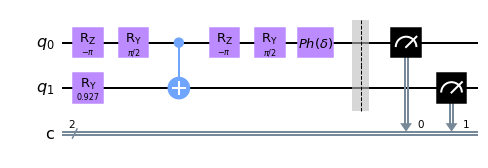

In [7]:
qc = QuantumCircuit(2,2)
# qc.initialize(b, 0)
phase = 0
phase = universal_be(qc,M_inv,range(2),phase)
global_phase_gate(qc,phase,0)

qc.save_statevector()
qc.measure(0,0)
qc.measure(1,1)
qc.draw(output="mpl")

solution: [1.125 0.375]
expectaion: [0.9 0.1]


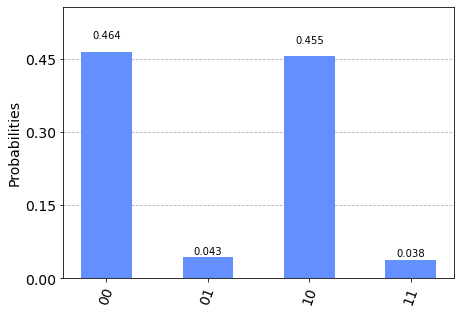

In [8]:
result = execute(qc, backend=backend, shots=1024, memory=True).result()
sv = result.get_statevector()
sol_vector = R*np.real(np.array([sv[0], sv[1]]))
print("solution:", sol_vector)

sol_prob = sol_vector**2/sum(sol_vector**2)
print("expectaion:",sol_prob)

plot_histogram(result.get_counts())

### Ex2.  

$A = \begin{bmatrix}15&9&5&-3\\9&15&3&-5\\5&3&15&-9\\-3&-5&-9&15\end{bmatrix}$, $b = \begin{bmatrix}0\\0\\0\\1\end{bmatrix}\longrightarrow  x = \begin{bmatrix}-0.09375\\0.15625\\0.28125\\0.46875\end{bmatrix}$

In [9]:
M = (1/4)*np.array([[15, 9, 5,-3],
                    [ 9,15, 3,-5],
                    [ 5, 3,15,-9],
                    [-3,-5,-9,15]])
b = np.array([0, 0, 0, 1])

classic_solution = np.linalg.solve(M,b)
norm = np.linalg.norm(classic_solution)
eigenvals,eigenvecs=np.linalg.eig(M)
print("Eigenvalues:",eigenvals)
print("Eigenvectors:\n",eigenvecs)
print("Euclidean norm:",norm)

Eigenvalues: [8. 4. 1. 2.]
Eigenvectors:
 [[ 0.5  0.5  0.5  0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]
 [-0.5  0.5 -0.5  0.5]]
Euclidean norm: 0.5762215285808053


HHL

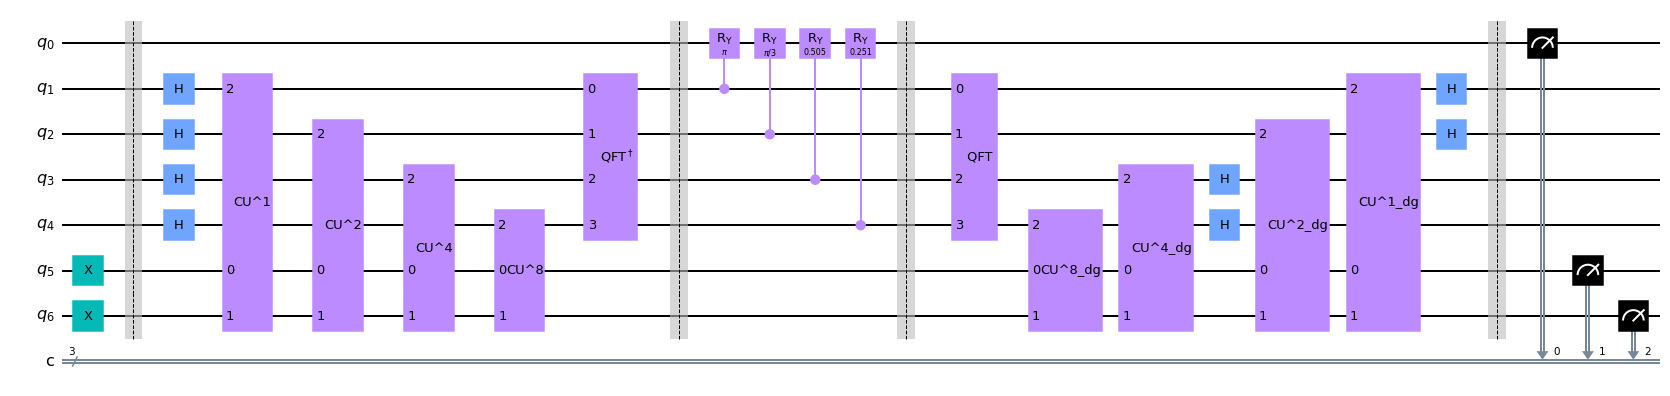

In [10]:
t = (1/8)*np.pi

def CU(A,num):
    qc = QuantumCircuit(3)
    U_A, C_U = np.eye(4, dtype='complex'), np.eye(8, dtype='complex')
    for i in range(num): U_A = U_A.dot(sp.linalg.expm(1j*A*t))
    C_U[4:8,4:8] = U_A 

    qc.unitary(Operator(C_U), range(3))
    CU_gate = qc.to_gate()
    CU_gate.name = "CU^{}".format(num)
    return CU_gate

qc = QuantumCircuit(7,3)
qc.x([5,6])

qc.barrier()

qc.h([1,2,3,4])
rep = 1
for i in range(4):
    qc.append(CU(M,rep),[5,6,i+1])
    rep*=2
  
qft_dagger(qc,4,1)
qc.barrier()

qc.cry(2*np.arcsin(1/1),1,0)
qc.cry(2*np.arcsin(1/2),2,0)
qc.cry(2*np.arcsin(1/4),3,0)
qc.cry(2*np.arcsin(1/8),4,0)
qc.barrier()

qft(qc,4,1)
rep = 8
for i in range(4):
    qc.append(CU(M,int(rep)).inverse(),[5,6,4-i])
    rep/=2 
qc.h([1,2,3,4])

qc.save_statevector()
qc.measure([0,5,6],[0,1,2])
qc.draw(output="mpl",fold=-1)

solution: [-0.09375  0.15625  0.28125  0.46875]


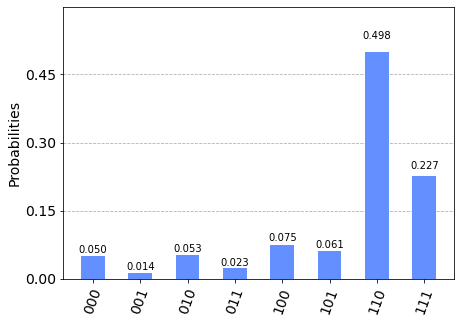

In [11]:
result = execute(qc, backend=backend, shots=1024, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[1], sv[33], sv[65], sv[97]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())

Block Encoding

In [12]:
M_inv = np.linalg.inv(M)
R = np.linalg.norm(M_inv)

if R > 1: 
    print("Inverse matrix:\n",np.round(M_inv,3))
    print("-> divisor:",R)
    M_inv = M_inv/R

print("Inverse matrix with norm < 1:\n",np.round(M_inv,3))

Inverse matrix:
 [[ 0.469 -0.281 -0.156 -0.094]
 [-0.281  0.469  0.094  0.156]
 [-0.156  0.094  0.469  0.281]
 [-0.094  0.156  0.281  0.469]]
-> divisor: 1.1524430571616109
Inverse matrix with norm < 1:
 [[ 0.407 -0.244 -0.136 -0.081]
 [-0.244  0.407  0.081  0.136]
 [-0.136  0.081  0.407  0.244]
 [-0.081  0.136  0.244  0.407]]


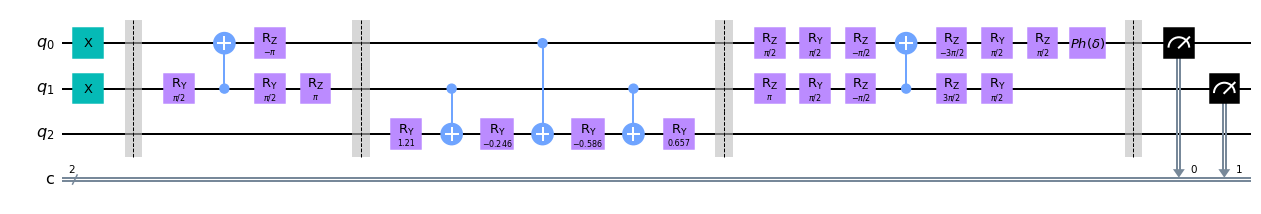

In [13]:
qc = QuantumCircuit(3,2)
# qc.initialize(b, [0,1])
qc.x([0,1])
qc.barrier()
phase = 0

from utils import universal_ud
from utils_decompose import ucry_decomposition_optimize
from utils_block_encode import block_encode_matrix, transfer_matrix
U, D, V = np.linalg.svd(M_inv, full_matrices=True)
M_enlarge,U_enlarge,D_enlarge,V_enlarge = block_encode_matrix(M,U,D,V,4)
phase = universal_ud(qc,V,range(2),phase)
qc.barrier()
ucry_decomposition_optimize(qc,3,np.real(D_enlarge@transfer_matrix(4)),range(3))
qc.barrier()
phase = universal_ud(qc,U,range(2),phase)
# phase = universal_be(qc,M_inv,range(3),phase)
global_phase_gate(qc,phase,0)

qc.save_statevector()
qc.measure([0,1],[0,1])
qc.draw(output="mpl", fold = -1)

solution: [-0.09375  0.15625  0.28125  0.46875]
expectaion: [0.02647059 0.07352941 0.23823529 0.66176471]


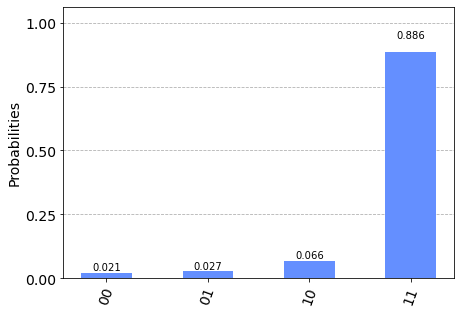

In [14]:
result = execute(qc, backend=backend, shots=1024, memory=True).result()
sv = result.get_statevector()
sol_vector = R*np.real(np.array([sv[0], sv[1], sv[2], sv[3]]))
print("solution:", sol_vector)

sol_prob = sol_vector**2/sum(sol_vector**2)
print("expectaion:",sol_prob)

plot_histogram(result.get_counts())

### Block Encoding Solver

In [15]:
rng = np.random.RandomState()

N = 5

A = rng.rand(N,N)*20-10 + (rng.rand(N,N)*20-10)*1j
print("A:\n",np.round(A,3))

b = rng.rand(N)*20-10 + (rng.rand(N)*20-10)*1j
print("b:\n",np.round(b,3))

A:
 [[-1.052-7.1j   -9.648-5.587j  8.646-8.881j  5.044+2.046j  9.986+6.413j]
 [ 5.433-8.514j  7.77 -5.5j    2.689-6.667j  1.988+0.423j  1.863-6.658j]
 [-4.98 +3.893j  3.941+9.172j  0.211+0.604j  9.499+4.682j -6.573-6.18j ]
 [-8.198-7.786j  8.555+9.781j -1.111+8.408j  1.016+5.443j -1.18 +5.466j]
 [-7.697+2.359j  2.205-2.111j -6.941-7.927j -6.802-0.907j  9.805-5.088j]]
b:
 [ 2.237-1.014j  4.444-5.867j  8.241+4.464j -5.704+9.018j -6.522-5.459j]


Classic sol:
 [-0.034-0.234j  0.082-0.2j    1.065+0.248j  0.174+0.31j  -0.307+0.439j]
BE Solver sol:
 [-0.034-0.234j  0.082-0.2j    1.065+0.248j  0.174+0.31j  -0.307+0.439j]
CNOT counts: 53


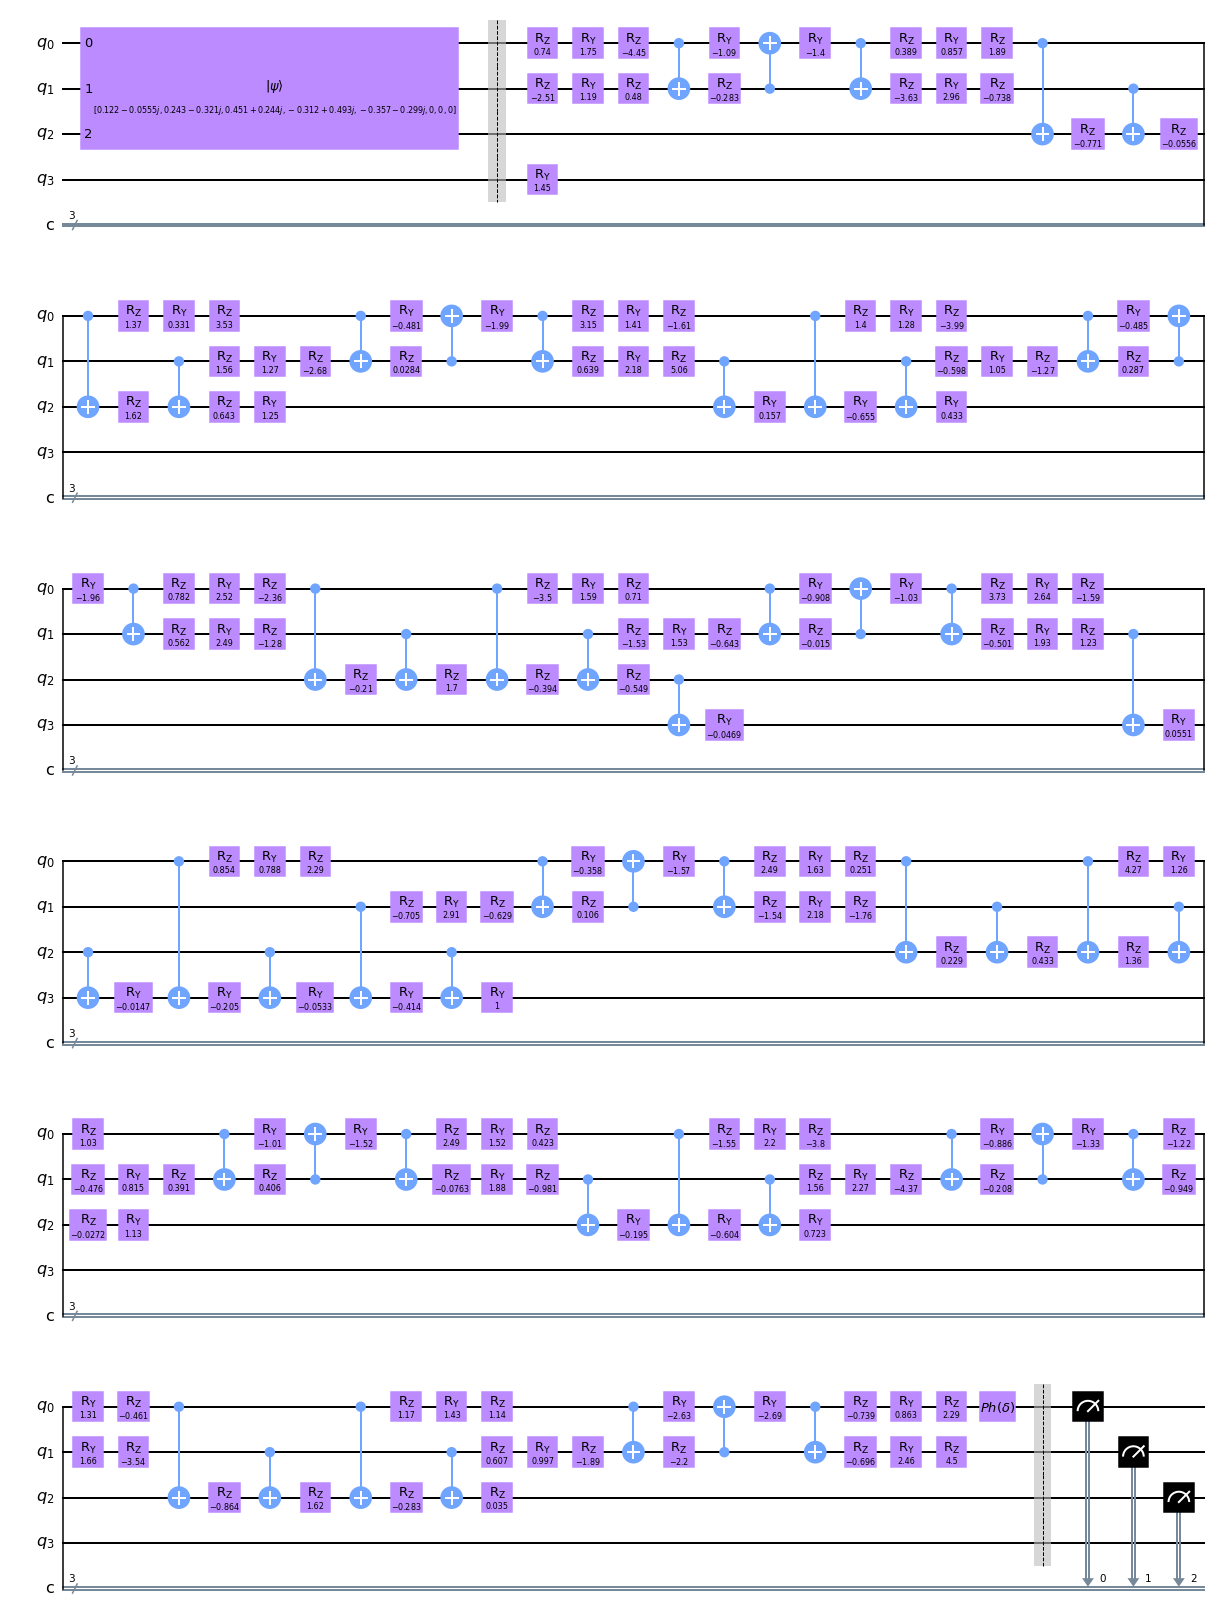

In [16]:
from utils import be_solver

classic_solution = np.linalg.solve(A,b)
print("Classic sol:\n",np.round(classic_solution,3))

qc,sol = be_solver(A,b)
print("BE Solver sol:\n",np.round(sol,3))
print("CNOT counts:", qc.count_ops()['cx'])
qc.draw(output="mpl")